# Convergence tests for grid stencils and boundary conditions

This notebook explores spatial convergence of the boundary conditions and laplace stencil defined in the voxelgrid class. Temporal convergence based on manufactured solutions will be explored in another notebook.

In [1]:
import voxelsss as vox
import numpy as np
from numpy import sin, cos, pi
import torch
import matplotlib.pyplot as plt

### Define generic convergence test

We use the discrete $L_2$–norm of the difference divided by the $L_2$–norm of the exact solution, i.e. a relative $L_2$ error to quantify convergence.

In [20]:
def grid_convergence_test(
    test_function,      # some function which return a torch tensor (shape [x,y,z])
    init_fun,           # exact init_fun(x,y,z)->np.ndarray
    exact_fun,          # exact_fun(x,y,z)->np.ndarray
    convention = 'cell_center',
    dtype = 'float32',
    powers = np.array([3,4,5,6,7]),
    backend = 'torch'
):
    dx     = np.zeros(len(powers))
    errors = np.zeros(len(powers))

    for i, p in enumerate(powers):
        if convention == 'cell_center':
            vf = vox.VoxelFields(2**p, 2**p, 2**p, (1,1,1), convention=convention)
        elif convention == 'staggered_x':
            vf = vox.VoxelFields(2**p+1, 2**p, 2**p, (1,1,1), convention=convention)
        vf.precision = dtype
        grid = vf.meshgrid()
        init_data = init_fun(*grid)

        if backend == 'torch':
            vg = vox.voxelgrid.VoxelGridTorch(vf.grid_info(), precision=vf.precision, device='cpu')
        elif backend == 'jax':
            vg = vox.voxelgrid.VoxelGridJax(vf.grid_info(), precision=vf.precision)
        field = vg.init_field_from_numpy(init_data)
        # Compute solutions
        comp = vg.export_field_to_numpy(test_function(vg, field, 0))
        exact = exact_fun(*grid)
        if convention == 'staggered_x':
            comp = comp[1:-1,:,:]
            exact = exact[1:-1,:,:]
            # @SIMON: is this a problem now that we dont have ghost nodes?

        # Error norm
        diff = comp - exact
        errors[i] = np.linalg.norm(diff)/np.linalg.norm(exact)
        dx[i]     = vf.spacing[0]

    return dx, errors

### Test 1: Laplacian stencil on periodic field

Grid spacing: [0.125     0.0625    0.03125   0.015625  0.0078125]
Errors:       [0.30522617 0.08629808 0.02225653 0.00560765 0.0014046 ]
Convergence rate from slope fit: 1.9471017692111288


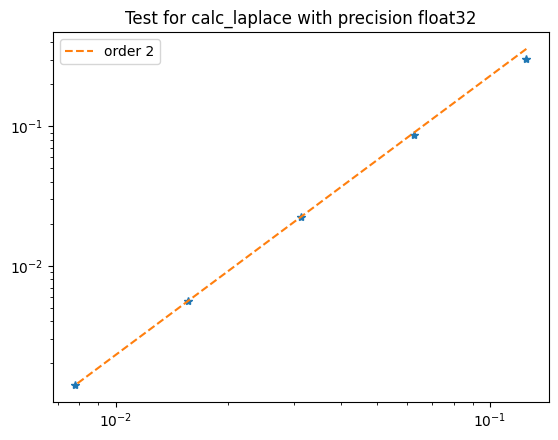

In [21]:
def init_fun(x,y,z):  
    return sin(2*pi*x)*sin(4*pi*y)*sin(6*pi*z) * ( 2**2 + 4**2 + 6**2)**(-1) *pi**(-2)

def laplace_init_fun(x,y,z):
    return -sin(2*pi*x)*sin(4*pi*y)*sin(6*pi*z)

def test_fun(vg, field, t):
    field = vg.apply_periodic_BC(vg.pad_with_ghost_nodes(field))
    laplace = vg.calc_laplace(field)
    return vg.return_inner_values(laplace)

precision = 'float32'
dx, errors = grid_convergence_test(
                    test_function  = test_fun,
                    init_fun       = init_fun,
                    exact_fun      = laplace_init_fun,
                    convention     = 'cell_center',
                    dtype          = precision
                )

print(f"Grid spacing: {dx}")
print(f"Errors:       {errors}")
# Take last error as reference value
err_const = errors[-1]/dx[-1]**2 
slope, _ = np.polyfit(np.log(dx), np.log(errors), 1)
print("Convergence rate from slope fit:", slope)

plt.loglog(dx, errors, '*')
plt.loglog(dx, err_const*dx**2, '--', label='order 2')
plt.legend()
plt.title(f'Test for calc_laplace with precision {precision}')
plt.show()


### Test 2: Laplacian on field with ZERO Dirichlet BCs in x direction

There are two ways to enforce Dirichlet boundary conditions depending on the grid convention.
1. Cell centered grid: Works with ghost nodes and the value of c outside the domain is set accordingly. Commonly, ``c = 2*c_BC - c[0]`` is used
2. In a staggered grid configuration, the nodes at which the concentration values are stored, actually lie on the domain boundary and can be set to the corresponding given boundary value

In [24]:
def calc_laplace_corr(vg, padded):
    laplace = (padded[:, 1:-1, 2:, 1:-1] + padded[:, 1:-1, :-2, 1:-1]) * vg.div_dx2[1] + \
              (padded[:, 1:-1, 1:-1, 2:] + padded[:, 1:-1, 1:-1, :-2]) * vg.div_dx2[2] - \
              2 * padded[:, 1:-1, 1:-1, 1:-1] * (vg.div_dx2[1]+vg.div_dx2[2])
    laplace[:,1:-1,:,:] += (padded[:, 3:-1, 1:-1, 1:-1] - 2*padded[:, 2:-2, 1:-1, 1:-1] + padded[:, 1:-3, 1:-1, 1:-1]) * vg.div_dx2[0]
    laplace[:,0,:,:]  += (padded[:, 2, 1:-1, 1:-1] - 3*padded[:, 1, 1:-1, 1:-1] + 2*0) * vg.div_dx2[0] *4/3
    laplace[:,-1,:,:] += (padded[:,-3, 1:-1, 1:-1] - 3*padded[:,-2, 1:-1, 1:-1] + 2*0) * vg.div_dx2[0] *4/3
    return laplace

Grid spacing: [0.125      0.0625     0.03125    0.015625   0.0078125  0.00390625]
Grid spacing 2: [0.125      0.0625     0.03125    0.015625   0.0078125  0.00390625]
Grid spacing 3: [0.125      0.0625     0.03125    0.015625   0.0078125  0.00390625]
Errors: [0.27566833 0.19684233 0.13959939 0.09879247 0.06987192 0.04940966]
Convergence rate from slope fit: 0.49662655997471256


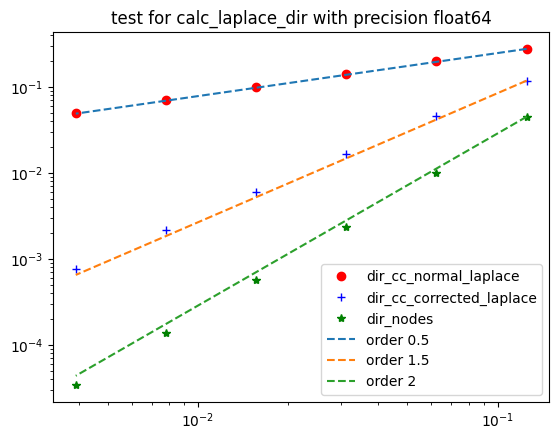

In [29]:
def init_fun(x,y,z):
    # return sin(2*pi*x)*sin(4*pi*y)*sin(6*pi*z) * ( 2**2 + 4**2 + 6**2)**(-1) *pi**(-2)
    return (x*(1-x))**2
    # return (x*(1-x))**3

def laplace_init_fun(x,y,z):
    # return -sin(2*pi*x)*sin(4*pi*y)*sin(6*pi*z)
    return 2 - 12*x + 12*x**2
    # return -6*x*(x - 1)*(x**2 + 3*x*(x - 1) + (x - 1)**2)
        
precision = 'float64'
powers = np.array([3,4,5,6,7,8])

# Use standard laplace and cell centered grid
def test_fun(vg, field, t):
    field = vg.apply_dirichlet_periodic_BC(vg.pad_with_ghost_nodes(field))
    laplace = vg.calc_laplace(field)
    return vg.return_inner_values(laplace)

dx1, errors1 = grid_convergence_test(
                    test_function = test_fun,
                    init_fun      = init_fun,
                    exact_fun     = laplace_init_fun,
                    convention    = 'cell_center',
                    dtype         = precision,
                    powers        = powers
                )

# Use corrected laplace and cell centered grid
def test_fun2(vg, field, t):
    field = vg.apply_dirichlet_periodic_BC(vg.pad_with_ghost_nodes(field))
    laplace = calc_laplace_corr(vg, field)
    return laplace

dx2, errors2 = grid_convergence_test(
                    test_function = test_fun2,
                    init_fun      = init_fun,
                    exact_fun     = laplace_init_fun,
                    convention    = 'cell_center',
                    dtype         = precision,
                    powers        = powers
                )

# Use staggered grid with boundary nodes
dx3, errors3 = grid_convergence_test(
                    test_function = test_fun,
                    init_fun      = init_fun,
                    exact_fun     = laplace_init_fun,
                    convention    = 'staggered_x',
                    dtype         = precision,
                    powers        = powers
                )

print(f"Grid spacing: {dx1}")
print(f"Grid spacing 2: {dx2}")
print(f"Grid spacing 3: {dx3}")
print(f"Errors: {errors1}")
slope, _ = np.polyfit(np.log(dx1), np.log(errors1), 1)
print("Convergence rate from slope fit:", slope) 

plt.loglog(dx1, errors1, 'o', color='red', label='dir_cc_normal_laplace')
plt.loglog(dx2, errors2, '+', color='blue', label='dir_cc_corrected_laplace')
plt.loglog(dx3, errors3, '*', color='green', label='dir_nodes')
plt.loglog(dx1, errors1[0]/dx1[0]**0.5*dx1**0.5, '--', label='order 0.5')
plt.loglog(dx2, errors2[0]/dx2[0]**1.5*dx2**1.5, '--', label='order 1.5')
plt.loglog(dx3, errors3[0]/dx3[0]**2*dx3**2, '--', label='order 2')
plt.legend()
plt.title(f'test for calc_laplace_dir with precision {precision}')
plt.show()

The big take-away: Enforcing Dirichlet boundary conditions on a cell centered grid does not maintain the 2nd order convergence! In this case, the staggered grid configuration performs much better.

### Test 3: Laplacian with NON-ZERO Dirichlet BCs in x-direction

Grid spacing: [0.125      0.0625     0.03125    0.015625   0.0078125  0.00390625]
Grid spacing: [0.125      0.0625     0.03125    0.015625   0.0078125  0.00390625]
Errors:       [0.29488273 0.17232296 0.11430919 0.07948786 0.05592993 0.03944828]
Errors:       [0.11570974 0.02822641 0.00696772 0.00173878 0.00047975 0.00066035]
Convergence rate from slope fit: 0.5687125057625357


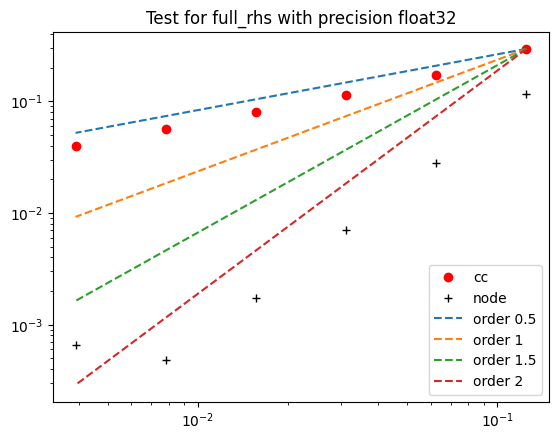

In [30]:
precision = 'float32'
bc_l, bc_r = (1, -1)
def init_fun(x,y,z):
    return cos(pi*x)**3

def laplace_init_fun(x,y,z):
    return  3*pi**2*(2*sin(pi*x)**2 - cos(pi*x)**2)*cos(pi*x)

def test_fun(vg, field, t):
    field = vg.apply_dirichlet_periodic_BC(vg.pad_with_ghost_nodes(field), bc0=bc_l, bc1=bc_r)
    laplace = vg.calc_laplace(field)
    return vg.return_inner_values(laplace)

dx, errors = grid_convergence_test(
                    test_function = test_fun,
                    init_fun      = init_fun,
                    exact_fun     = laplace_init_fun,
                    convention    = 'cell_center',
                    dtype         = precision,
                    powers        = powers
                )

dx2, errors2 = grid_convergence_test(
                    test_function = test_fun,
                    init_fun      = init_fun,
                    exact_fun     = laplace_init_fun,
                    convention    = 'staggered_x',
                    dtype         = precision,
                    powers        = powers
                )

print(f"Grid spacing: {dx}")
print(f"Grid spacing: {dx2}")
print(f"Errors:       {errors}")
print(f"Errors:       {errors2}")
slope, _ = np.polyfit(np.log(dx), np.log(errors), 1)
print("Convergence rate from slope fit:", slope)

plt.loglog(dx, errors, 'o', label='cc', color='red')
plt.loglog(dx2, errors2, '+', label='node', color='black')
plt.loglog(dx, errors[0]/dx[0]**0.5*dx**0.5, '--', label = 'order 0.5')
plt.loglog(dx, errors[0]/dx[0]*dx,'--', label = 'order 1')
plt.loglog(dx, errors[0]/dx[0]**1.5*dx**1.5,'--', label = 'order 1.5')
plt.loglog(dx, errors[0]/dx[0]**2*dx**2,'--', label = 'order 2')
plt.legend()
plt.title(f'Test for full_rhs with precision {precision}')
plt.show()

### Test 4: Laplacian with zero-flux BCs in x-direction

Grid spacing: [0.125      0.0625     0.03125    0.015625   0.0078125  0.00390625]
Grid spacing: [0.125      0.0625     0.03125    0.015625   0.0078125  0.00390625]
Errors:       [0.10484978 0.02713471 0.00684267 0.00171438 0.00042883 0.00010722]
Errors:       [1.66130648e-01 3.01574177e-02 7.02680443e-03 1.73098432e-03
 4.30686655e-04 1.07445758e-04]
Convergence rate from slope fit: 1.9890078555945498
Convergence rate from slope2 fit: 2.0966553585071006


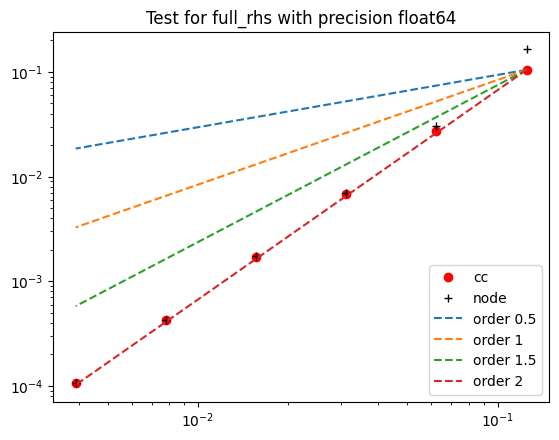

In [31]:
precision = 'float64'

def init_fun(x,y,z):
    # return (x*(1-x))**2
    return cos(pi*x)**3
    # return cos(2*pi*x)*sin(4*pi*y)*sin(6*pi*z) / (2**2 + 4**2 + 6**2) / pi**2

def laplace_init_fun(x,y,z):
    # return 2 - 12*x + 12*x**2
    return  3*pi**2*(2*sin(pi*x)**2 - cos(pi*x)**2)*cos(pi*x)
    # return -cos(2*pi*x)*sin(4*pi*y)*sin(6*pi*z)
    
def test_fun(vg, field, t):
    field = vg.apply_zero_flux_periodic_BC(vg.pad_with_ghost_nodes(field))
    laplace = vg.calc_laplace(field)
    return vg.return_inner_values(laplace)

dx, errors = grid_convergence_test(
                    test_function = test_fun,
                    init_fun      = init_fun,
                    exact_fun     = laplace_init_fun,
                    convention    = 'cell_center',
                    dtype         = precision,
                    powers        = powers
                )

dx2, errors2 = grid_convergence_test(
                    test_function = test_fun,
                    init_fun      = init_fun,
                    exact_fun     = laplace_init_fun,
                    convention    = 'staggered_x',
                    dtype         = precision,
                    powers        = powers
                )

print(f"Grid spacing: {dx}")
print(f"Grid spacing: {dx2}")
print(f"Errors:       {errors}")
print(f"Errors:       {errors2}")
slope, _ = np.polyfit(np.log(dx), np.log(errors), 1)
slope2, _ = np.polyfit(np.log(dx2), np.log(errors2), 1)
print("Convergence rate from slope fit:", slope)
print("Convergence rate from slope2 fit:", slope2)

plt.loglog(dx, errors, 'o', label='cc', color='red')
plt.loglog(dx2, errors2, '+', label='node', color='black')
plt.loglog(dx, errors[0]/dx[0]**0.5*dx**0.5, '--', label = 'order 0.5')
plt.loglog(dx, errors[0]/dx[0]*dx,'--', label = 'order 1')
plt.loglog(dx, errors[0]/dx[0]**1.5*dx**1.5,'--', label = 'order 1.5')
plt.loglog(dx, errors[0]/dx[0]**2*dx**2,'--', label = 'order 2')
plt.legend()
plt.title(f'Test for full_rhs with precision {precision}')
plt.show()